In [8]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import datetime
import tensorflow as tf
from functools import reduce
%matplotlib inline
plt.style.use('ggplot')

In [17]:

posfilename = 'WB_ZB_SNP_DATA_19990225-20180403.csv'
posDF = pd.read_csv(posfilename) 
posDF = posDF[posDF['SPECIES']=='WB']
posDF = posDF[posDF['migrant']==1]
posDF = posDF[posDF['OWNER']=='HOPCRAFT']



/home/staff1/ctorney/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


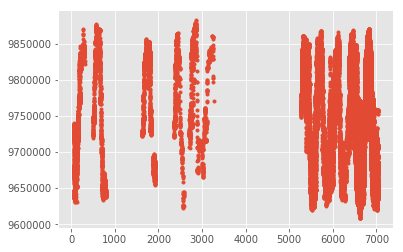

In [18]:

X = posDF['y'].values
Y = posDF['x'].values
dates = posDF['Date'].values.copy()
t = np.zeros(len(dates))

import datetime
strdate =posDF['Date'].min()

sdate = datetime.datetime.strptime("1999-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")
for i in range(len(t)):
    dt1 = datetime.datetime.strptime(dates[i], "%Y-%m-%d %H:%M:%S")
    delta =  (dt1 - sdate).total_seconds() / datetime.timedelta(days=1).total_seconds()
    t[i]=delta
    
X = X.reshape(len(X), 1)
Y = Y.reshape(len(Y), 1)
t = t.reshape(len(t), 1)
plt.plot(t,X,'.')


In [19]:

    
class ChangePoint(gpflow.kernels.Combination):
    def __init__(self, kern_list, offset, variance):
        super(ChangePoint, self).__init__(kern_list)
        self.offset = gpflow.Param(offset)
        self.variance = gpflow.Param(variance)


    def K(self, X, X2=None, presliced=False):
        # assert len(self.kern_list) != 3, "has to have two kernels only"
        if X2 is None:
            X2 = X
        #XXT = self.variance * tf.squeeze(tf.matmul(tf.expand_dims(X, axis=1), tf.expand_dims(X, axis=2))) + self.offset
        #XXT2 = self.variance * tf.squeeze(tf.matmul(tf.expand_dims(X2, axis=1), tf.expand_dims(X2, axis=2))) + self.offset
        XXT = self.variance * tf.squeeze(X-self.offset)
        XXT2 = self.variance *tf.squeeze(tf.transpose(X2)-self.offset)
        sigm = tf.sigmoid(XXT)
        sigm2 = tf.sigmoid(XXT2)
        sig1 = tf.matmul(tf.expand_dims(sigm, axis=1),
                         tf.expand_dims(sigm2, axis=0))
        sig2 = tf.matmul(tf.expand_dims((1. - sigm), axis=1),
                         tf.expand_dims((1. - sigm2), axis=0))
        a1 = reduce(tf.multiply,
                    [sig1, self.kernels[0].K(X, X2)])
        a2 = reduce(tf.multiply,
                    [sig2, self.kernels[1].K(X, X2)])
        return reduce(tf.add, [a1, a2])


    def Kdiag(self, X, presliced=False):
        # assert len(self.kern_list) != 3, "has to have two kernels only"
        #XXT = self.variance * tf.squeeze(tf.matmul(tf.expand_dims(X, axis=1), tf.expand_dims(X, axis=2))) + self.offset
        XXT = self.variance * tf.squeeze(X-self.offset)

        sigm = tf.sigmoid(XXT)
        a1 = reduce(tf.multiply, [sigm, self.kernels[0].Kdiag(X),
                             sigm])
        a2 = reduce(tf.multiply, [(1. - sigm), self.kernels[1].Kdiag(X),
                             1. - sigm])
        return reduce(tf.add, [a1, a2])

In [20]:
np.max(t)

7033.104166666667

In [20]:
T1 = t

X1 = X/100000
X1 = X1.reshape(len(X1),1)
Y1 = Y/100000
Y1 = Y1.reshape(len(Y1),1)

T1 = T1.reshape(len(T1),1)

k1 = gpflow.kernels.Periodic(1,period=364.25, variance=10.0, lengthscales=100)
k1.period.trainable=False
k2 = gpflow.kernels.Periodic(1,period=364.25, variance=10.0, lengthscales=100)
k2.period.trainable=False
k=ChangePoint([k1,k2],offset=4000.0,variance=1.0)
M=100
Z = T1[::M, :].copy()
XY = np.hstack((Y1,X1))
m = gpflow.models.SGPR(T1, XY, kern=k,Z=Z)
m.likelihood.variance = 1.0
gpflow.train.ScipyOptimizer().minimize(m)


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 53956.752673
  Number of iterations: 42
  Number of functions evaluations: 87


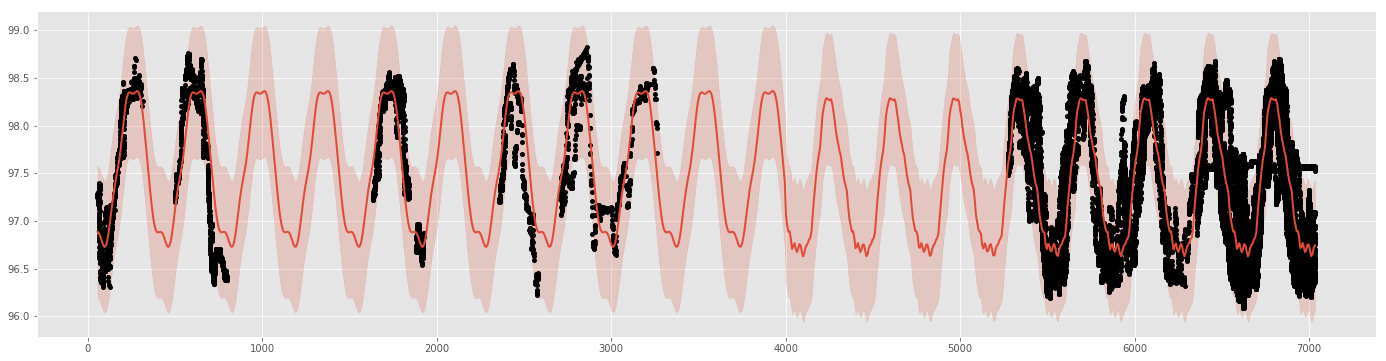

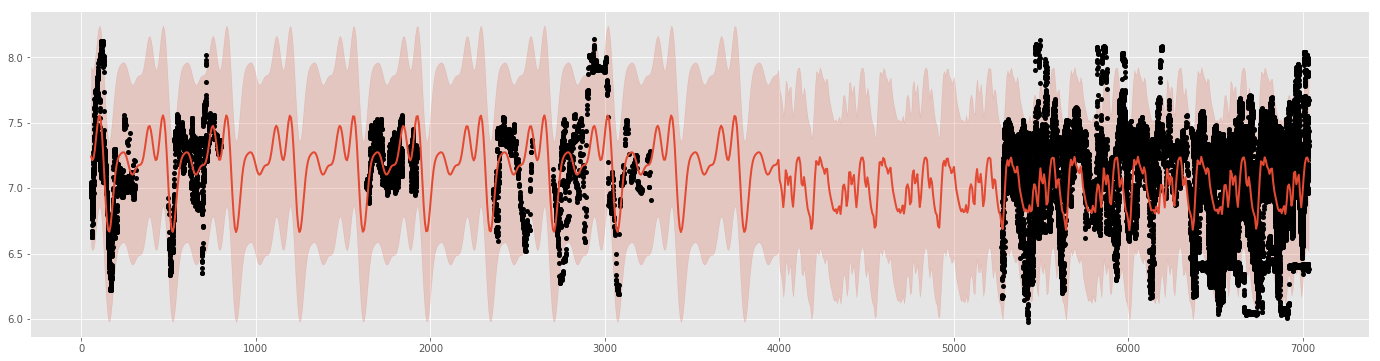

In [21]:
xx = np.linspace(min(T1), max(T1), 1000).reshape(1000, 1)
mean, var = m.predict_y(xx)
plt.figure(figsize=(24, 6))
plt.plot(T1, X1, 'k.', mew=2)
plt.plot(xx, mean[:,1], 'C0', lw=2)
plt.fill_between(xx[:,0],
                 mean[:,1] - 2*np.sqrt(var[:,1]),
                 mean[:,1] + 2*np.sqrt(var[:,1]),
                 color='C0', alpha=0.2)
plt.show()
plt.figure(figsize=(24, 6))
plt.plot(T1, Y1, 'k.', mew=2)
plt.plot(xx, mean[:,0], 'C0', lw=2)
plt.fill_between(xx[:,0],
                 mean[:,0] - 2*np.sqrt(var[:,0]),
                 mean[:,0] + 2*np.sqrt(var[:,0]),
                 color='C0', alpha=0.2)
plt.show()

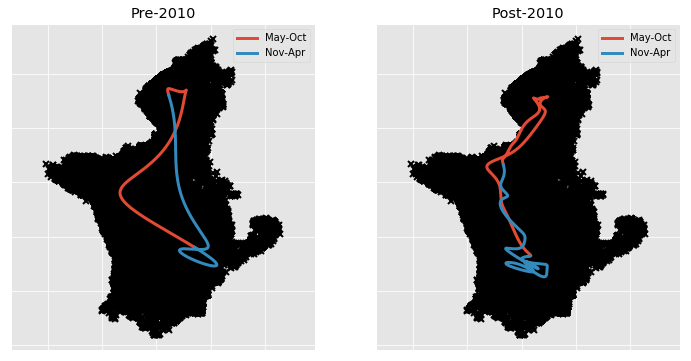

In [31]:
fig = plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
month=6
stopper = int(month*30*1000/365)
xx = np.linspace(0+120, 0+365+120, 1000).reshape(1000, 1)
meanY, varY = m.predict_y(xx)
plt.plot(Y1, X1, 'kx', mew=2)

#stopper = int(month*30)
plt.plot(meanY[:stopper,0], meanY[:stopper,1],  lw=3,label='May-Oct')
plt.plot(meanY[stopper:,0], meanY[stopper:,1],  lw=3,label='Nov-Apr')
plt.axis('equal')
plt.title('Pre-2010')
plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')
plt.legend()


plt.subplot(1, 2, 2)
xx = np.linspace(365*15+120, 365*16+120, 1000).reshape(1000, 1)
#xx = np.linspace(4000, max(T1), 1000).reshape(1000, 1)
meanY, varY = m.predict_y(xx)
plt.plot(Y1, X1, 'kx', mew=2)
plt.plot(meanY[:stopper,0], meanY[:stopper,1],  lw=3,label='May-Oct')
plt.plot(meanY[stopper:,0], meanY[stopper:,1],  lw=3,label='Nov-Apr')
plt.axis('equal')
plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off', labelleft='off', labeltop='off', labelright='off', labelbottom='off')

plt.legend()
plt.title('Post-2010')
plt.savefig('wildies.png')
plt.show()

In [26]:
meanY.shape

(1000, 2)